# Predicting GW signals from LISA WDWDs

In [2]:
import numpy as np
import astropy.units as u
import pandas as pd
import matplotlib.pyplot as plt

import cogsworth

In [3]:
# ensure jupyter actually uses your fancy retina display
%config InlineBackend.figure_format = 'retina'

# make pandas show *every* column
pd.set_option("display.max_columns", None)

# various adjustments to matplotlib settings
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Mask out WDWDs
Run a population and select out the double white dwarfs

In [5]:
p = cogsworth.pop.Population(1000, final_kstar1=[10, 11, 12])
p.create_population()

Run for 1000 binaries
Ended up with 1060 binaries with m1 > 0 solar masses
[1e-02s] Sample initial binaries
[1.5s] Evolve binaries (run COSMIC)


1075it [00:05, 195.63it/s]                          


[7.3s] Get orbits (run gala)
Overall: 8.9s


In [11]:
wdwd_mask = (p.final_bpp["kstar_1"].isin([10, 11, 12]) & p.final_bpp["kstar_2"].isin([10, 11, 12]))
wdwd_mask.sum()

34

# Custom star formation history
Let's define a custom star formation history for a nearby burst of star formation

In [72]:
class NearbyBurst(cogsworth.sfh.BurstUniformDisc):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def draw_radii(self, size, **kwargs):
        return np.random.uniform(7.5, 8.5, size) * u.kpc
    
    def draw_phi(self, **kwargs):
        return np.ones(len(self)) * np.pi / 2 * u.rad

In [73]:
NearbyBurst(100000).x

<Quantity [8.27574902, 7.60303783, 8.3783069 , ..., 7.51833452, 8.42378291,
           7.98020805] kpc>

In [105]:
p = cogsworth.pop.Population(1000, final_kstar1=[10, 11, 12], sfh_model=NearbyBurst)
p.create_population()

Run for 1000 binaries
Ended up with 1054 binaries with m1 > 0 solar masses
[1e-02s] Sample initial binaries


[1.8s] Evolve binaries (run COSMIC)


1063it [00:08, 127.64it/s]                         


[11.1s] Get orbits (run gala)
Overall: 13.0s


## Transform to LEGWORK sources
We can transform from `cogsworth` to `LEGWORK` to estimate LISA detectability.

In [106]:
wdwd_mask = (p.final_bpp["kstar_1"].isin([10, 11, 12]) & p.final_bpp["kstar_2"].isin([10, 11, 12]))

In [107]:
wdwds = p[wdwd_mask]

In [108]:
wdwd_legwork = wdwds.to_legwork_sources(assume_mw_galactocentric=True)

In [109]:
wdwd_legwork.get_snr().max()

0.19345903585668853

## Let's move them a little closer
Use a fixed set of distances that are closer to the Earth to increase SNR

In [110]:
wdwd_legwork = wdwds.to_legwork_sources(distances=np.ones(len(wdwds)) * u.pc)
wdwd_legwork.get_snr().max()

2072.3624290270914

In [114]:
# this is the time of the soonest merger in the population
wdwd_legwork.get_merger_time().min().to(u.Myr)

<Quantity 45.30696317 Myr>

# Plot on sensitivity curve

Let's see how these sources look on the LISA sensitivity curve

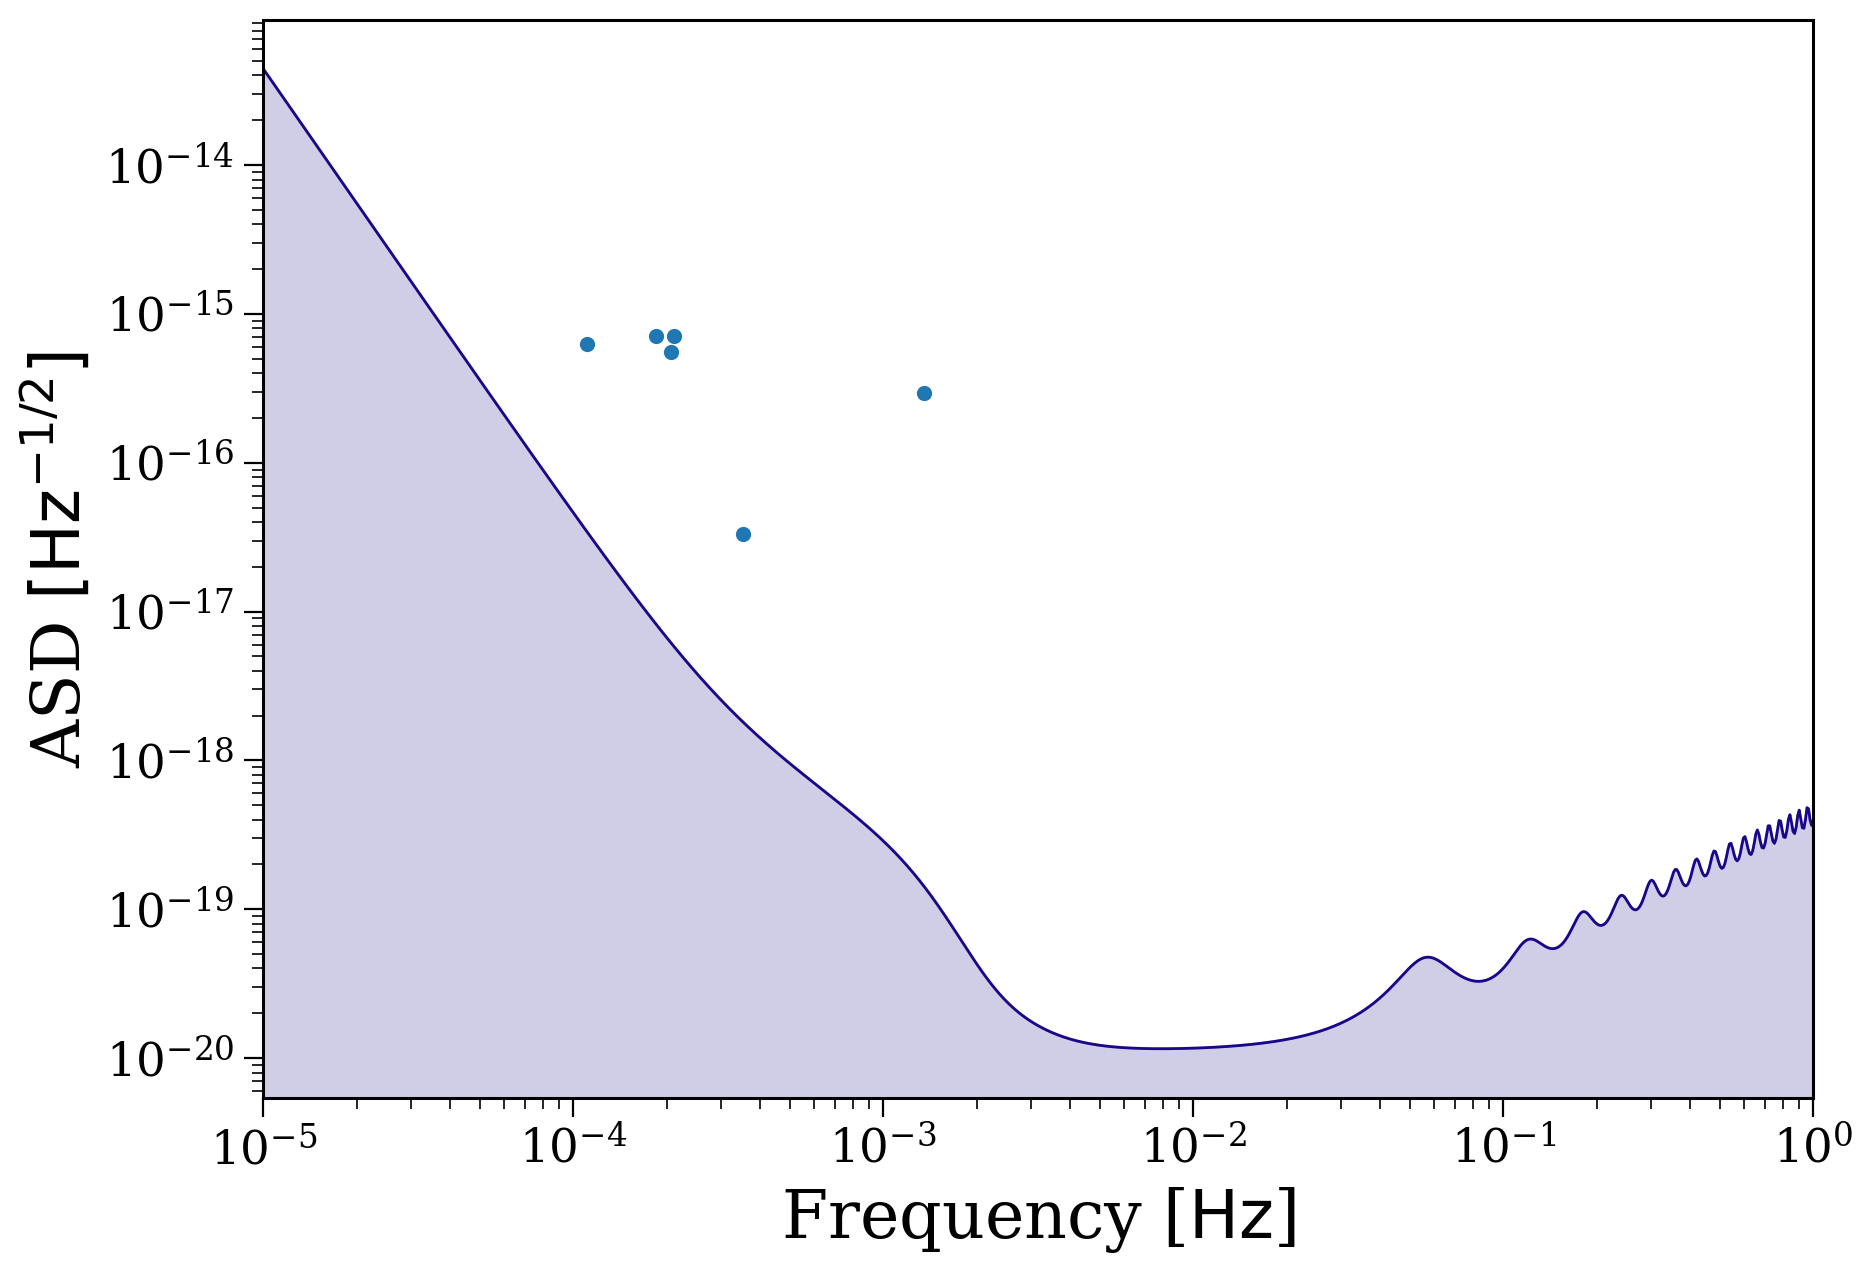

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='Frequency [$\\rm Hz$]', ylabel='ASD $[\\rm Hz^{-1/2}]$'>)

In [111]:
wdwd_legwork.plot_sources_on_sc()